In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

In [3]:
df1=pd.read_csv('traffic_training.csv')

In [4]:
df1.isnull().sum()

geohash6     0
day          0
timestamp    0
demand       0
dtype: int64

In [5]:
df_n=df1.groupby(['geohash6','day']).count()
df_n=df_n[['timestamp']]
df_n.head()

timestamp
geohash6 day           
qp02yc   1            7
         2            5
         3            7
         4           13
         5            4

In [6]:
df_d=df1.groupby(['geohash6','day']).sum()
df_d=df_d[['demand']]
df_d.head()

demand
geohash6 day          
qp02yc   1    0.069709
         2    0.116512
         3    0.125697
         4    0.291252
         5    0.071204

In [7]:
df_all=pd.merge(df_n,df_d, left_index=True, right_index=True)

In [8]:
df_an=df_all.reset_index(level=['geohash6', 'day'])

In [47]:
df_an.groupby(['geohash6']).sum().sort_values('demand').sample(n=10)

,day,timestamp,demand
geohash6,,,
qp08fn,1787,1249,31.553530
qp09tt,1891,2855,66.693651
qp0d02,1891,669,3.063478
qp03t9,1891,4801,252.461837
qp06pw,1891,3759,63.841202
qp0d1w,1891,1155,15.032097
qp06pn,1891,1669,13.406353
qp06p0,1891,1827,15.385037
qp08gp,1891,1959,29.631380


In [48]:
df_sel=df_an.loc[df_an['geohash6']=='qp08fn']
df_sel=df_sel[['day','demand']]
df_sel=df_sel.set_index('day')
df_sel = df_sel['demand']

df_sel.head()

day
1    0.197521
2    0.765643
3    0.750995
4    1.763051
5    0.318110
Name: demand, dtype: float64

In [49]:
index=range(1,62)
index

columns=['demands']
df_null = pd.DataFrame(index=index, columns=columns)
df_null.head()

,demands
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN


In [50]:
df_for=df_null.join(df_sel)
df_for=df_for[['demand']].fillna(0)
df_for.head()

,demand
1,0.197521
2,0.765643
3,0.750995
4,1.763051
5,0.318110


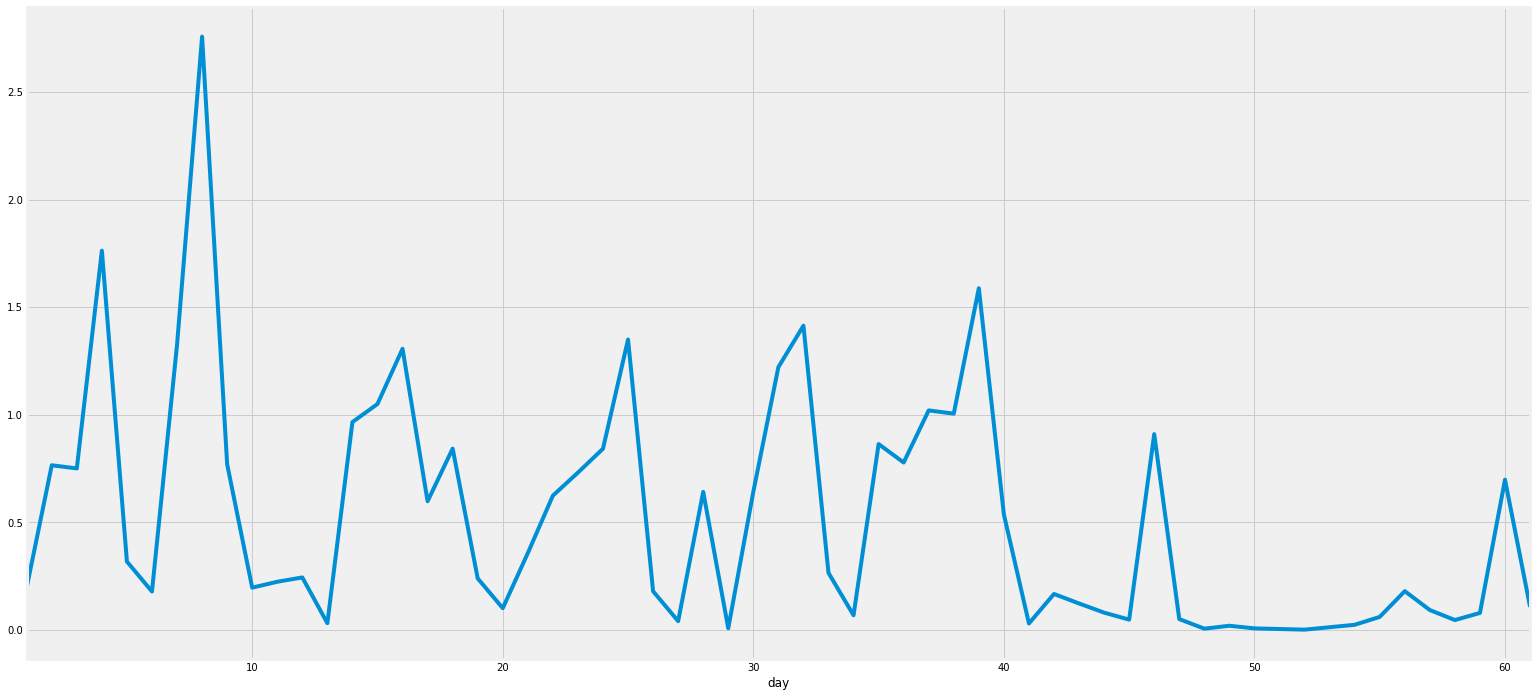

In [51]:
df_sel.plot(figsize=(24,12))

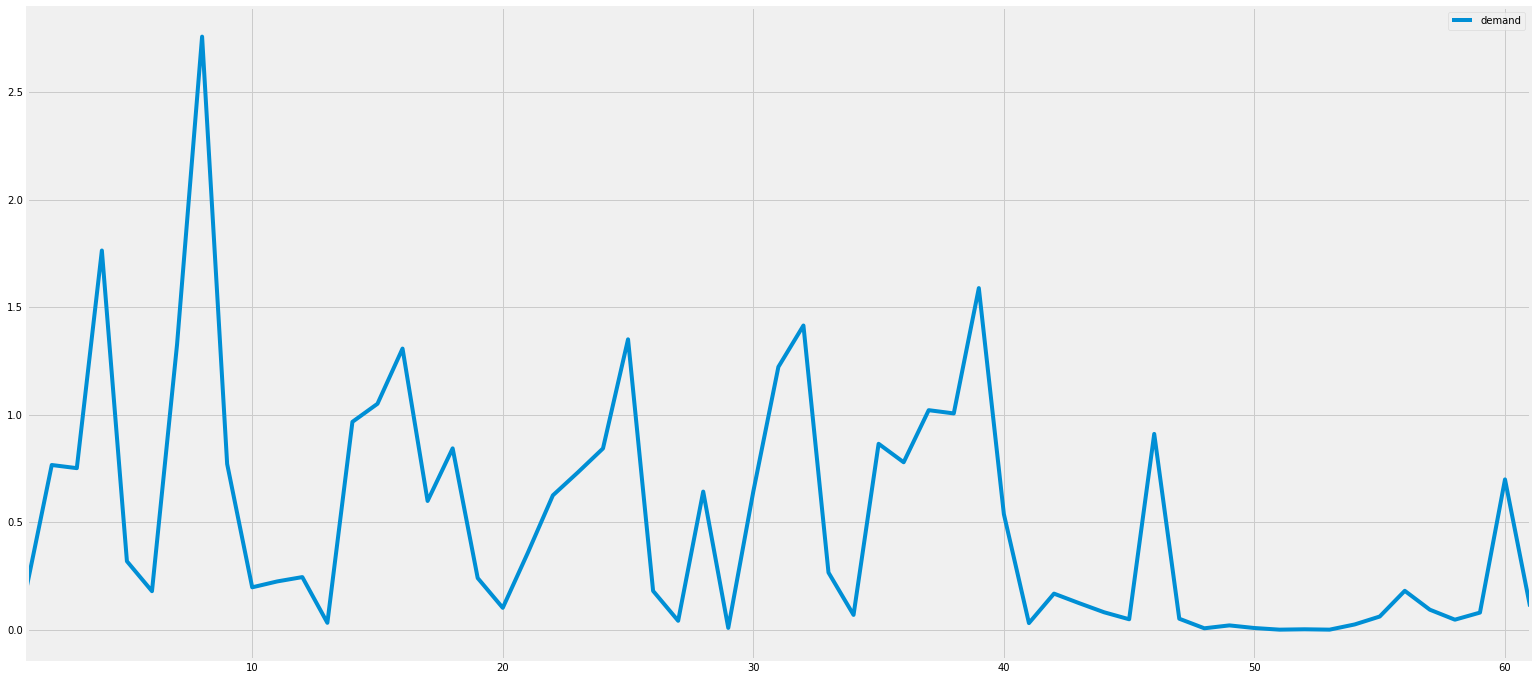

In [52]:
df_for.plot(figsize=(24,12))

In [53]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [56]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
arimaval=5000
count=0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_for,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        if results.aic<arimaval:  
            arimaval=results.aic
        else:
            arimaval=arimaval
        count+=1

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:140.01221945567804
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:72.29922090451491
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:82.51094199987402
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:55.71346336489576
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:90.52963470159811
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:60.5410640335497
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:63.782755119732
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:57.67728853360918
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:113.31426221032613
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:58.72427469469271
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:78.0036740808314
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:42.643180004514264
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:86.73273213598885
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:54.9614463592267
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:51.67054768233472
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:43.789139552228676
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:111.45574900638039
ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:64.42006717339703
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC:94.93080761

In [55]:
print(arimaval)

40.40600700671172


In [57]:
mod = sm.tsa.statespace.SARIMAX(df_for,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4808      0.241      1.997      0.046       0.009       0.953
ma.L1          0.1147      0.271      0.423      0.673      -0.417       0.647
ma.S.L7       -0.2400      0.113     -2.123      0.034      -0.462      -0.018
sigma2         0.1202      0.024      4.958      0.000       0.073       0.168


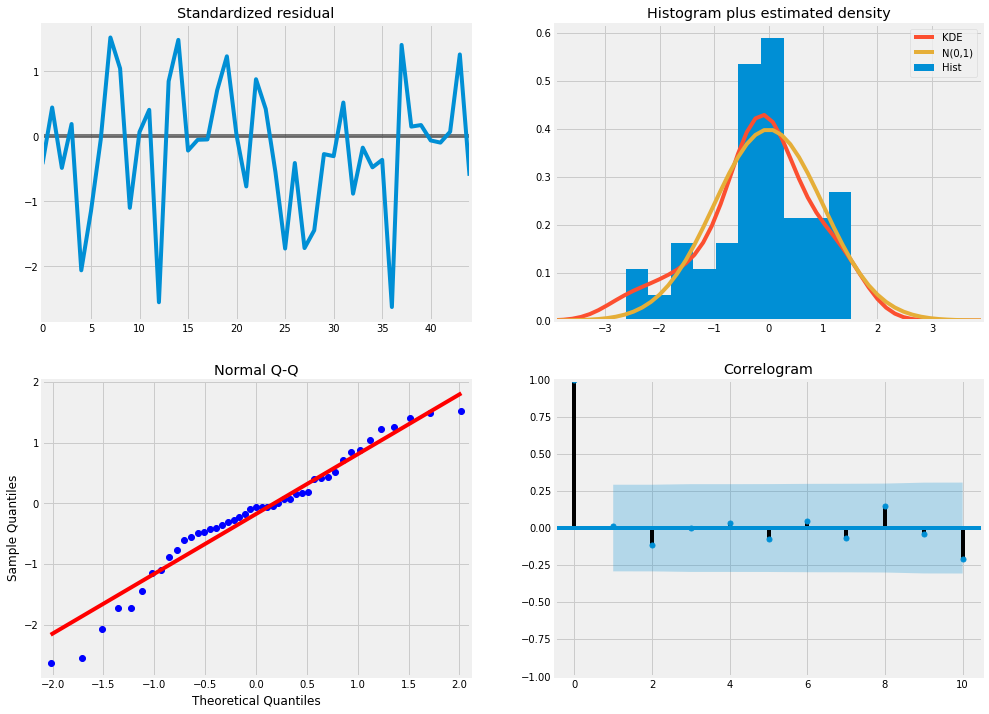

In [58]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [59]:
pred = results.get_prediction(start=50, dynamic=False)
pred_ci = pred.conf_int()
pred

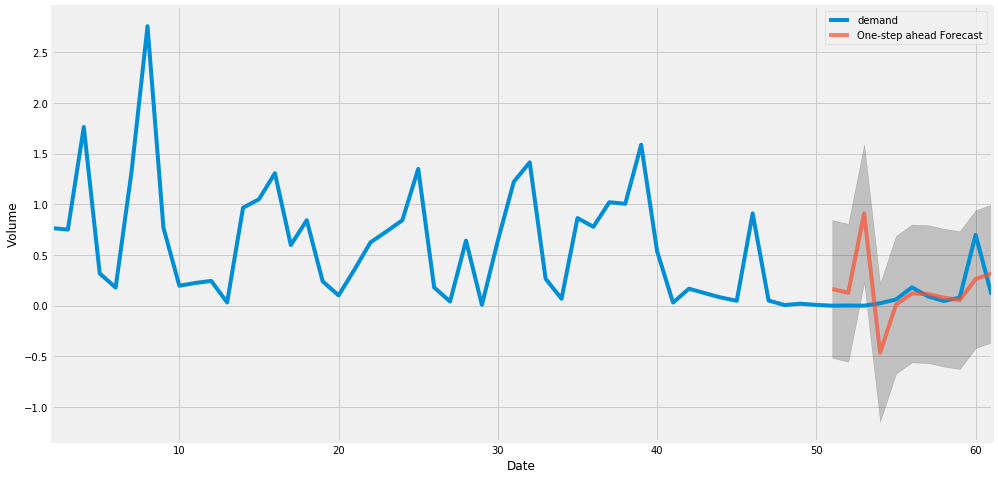

In [60]:
ax = df_for[1:].plot(label='observed', figsize=(15, 8))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(15, 8))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()

plt.show()

In [61]:
y_forecasted = pred.predicted_mean
y_truth = df_for['demand'][50:]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.12


In [62]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=10)


# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

pred_ci1=pred_ci
pred_ci1['Forecast']=(pred_ci1['lower demand']+pred_ci1['upper demand'])/2
pred_ci1

,lower demand,upper demand,Forecast
62,-0.628451,0.730830,0.051189
63,-0.631045,0.951038,0.159996
64,-0.728108,0.901154,0.086523
65,-0.768049,0.871928,0.051940
66,-0.744198,0.898246,0.077024
67,-0.229460,1.413553,0.592047
68,-0.726495,0.916650,0.095078
69,-0.922271,1.023969,0.050849
70,-0.861478,1.181144,0.159833
71,-0.945688,1.118576,0.086444


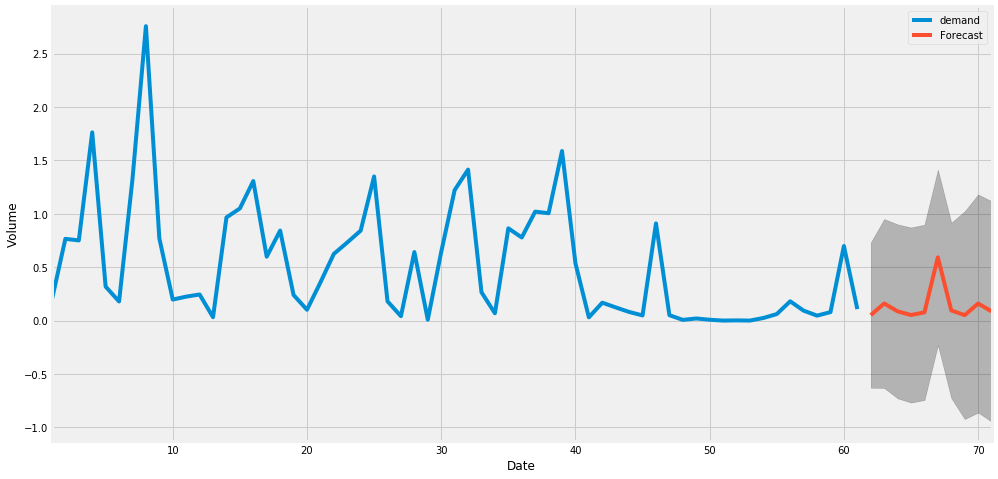

In [63]:
ax = df_for.plot(label='observed', figsize=(15, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')

plt.legend()
plt.show()